<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Подготовка-текста" data-toc-modified-id="Подготовка-текста-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка текста</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Знакомство с данными

In [1]:
import re
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

In [2]:
try:
    initial_data = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    raise Exception('Something is wrong. Check the file')

In [3]:
initial_data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Видим, что датасет состоит из двух столбцов с текстами правок и оценкой токсичности, где 1 — текст токсичен. Именно последний признак мы хотим научить модель предсказывать. Это будет считаться задачей классификации.

### Предобработка данных

Перед обучением проверим датасет на дубликаты, баланс классов и язык текстов (модель нужно обучать на нужный язык). Пропусков в датасете нет.

In [5]:
data = initial_data.copy()

In [6]:
# проверим наличие дубликатов
data.duplicated().sum()

0

In [7]:
# проверим баланс классов
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Видим, что классы несбалансированны. Нам нужно будет это учесть при обучении модели.

In [8]:
# проверим наличие кириллических букв, кажется, что в датасете только английский язык
found_cyrillic = data['text'].str.contains(r'[а-яА-ЯёЁ]')
found_cyrillic.value_counts()

False    159033
True        259
Name: text, dtype: int64

Регулярные выражения нашли в 259 текстах кириллические символы. Возможно, там текст на русском языке. Нужно проверить.

In [9]:
found_cyrillic_text = data[data['text'].str.contains(r'[а-яА-ЯёЁ]', flags=re.IGNORECASE, regex=True)]

# закомментирировано, чтобы список постов не выводился после анализа
#for text in found_cyrillic_text['text']:
    #print(text)

При изучении постов обнаружено, что там используются кириллические символы при описании чего-либо или при переводе на русский, но сами посты на английском языке. Так как эти посты занимают лишь малую часть всего датасета, то мы можем их просто удалить без ущерба для обучения. На другие языки проверям не будем.

In [10]:
# удаляем эти тексты
data = data.drop(index=found_cyrillic_text['text'].index)

In [11]:
# пересчитаем индексы
data = data.reset_index(drop=True)

### Подготовка текста

Перед обучением нам также нужно подготовить сами данные для модели.

In [12]:
# обозначим единый рандом
RANDOM_STATE = 999

In [13]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [14]:
# лемматизируем текст
def clear_and_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [15]:
# добавим леммы
data['lemm_text'] = data['text'].apply(clear_and_lemmatize)

In [16]:
# загрузим стопслова
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\themj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# получим обучающую и тестовую выборку с сохранением пропорций целевого признака 
features_train, features_test, target_train, target_test = train_test_split(
    data[['text', 'lemm_text']], data['toxic'], test_size=0.4, stratify=data['toxic'], random_state=RANDOM_STATE)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.4, stratify=target_train, random_state=RANDOM_STATE)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((57251, 2), (63614, 2), (57251,), (63614,))

In [18]:
# сбросим индексы для дальнейшей конкатенации массивов
features_train = features_train.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)

In [19]:
# зададим стоп-слова
stopwords = set(nltk_stopwords.words('english'))

In [20]:
# векторизуем тексты
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords), max_features=5000) 
tf_idf_train = count_tf_idf.fit_transform(features_train['lemm_text'])
tf_idf_valid = count_tf_idf.transform(features_valid['lemm_text'])
tf_idf_test = count_tf_idf.transform(features_test['lemm_text'])

In [21]:
# добавим TF-IDF признаки в обучающую выборку и оставим только вектора признаков
all_train = pd.concat([features_train, pd.DataFrame(tf_idf_train.toarray())], axis=1).drop(['text', 'lemm_text'], axis=1)
all_valid = pd.concat([features_valid, pd.DataFrame(tf_idf_valid.toarray())], axis=1).drop(['text', 'lemm_text'], axis=1)

# и в тестовую
all_test = pd.concat([features_test, pd.DataFrame(tf_idf_test.toarray())], axis=1).drop(['text', 'lemm_text'], axis=1)

Теперь можем перейти к обучению моделей.

## Обучение

Попробуем 4 модели: логистическую регрессию, стохастический градиентный спуск, случайный лес для классификации и градиентный бустинг для классификации. Так как классы у нас не сбаланасированны, то будем указывать гипер-параметр class_weight.

In [22]:
model_log_res = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')
model_log_res.fit(all_train, target_train)
preds_log_res = model_log_res.predict(all_valid)
print(f'F1: {f1_score(target_valid, preds_log_res)}')

F1: 0.7064060803474486


Значение не доходит до требуемого. Попробуем изменить отсечку.

In [23]:
probs_log_res = model_log_res.predict_proba(all_valid)

best_td = 0
best_f1 = 0

for i in np.arange(0.01, 0.99, 0.01):
    proba_n = np.where(probs_log_res[:,1] >= i, 1, 0)
    f1_n = f1_score(target_valid, proba_n)
    if f1_n > best_f1:
        best_f1 = f1_n
        best_td = i

best_td, best_f1    

(0.76, 0.7592052243990552)

С настройкой отсечки нам удалось получить удовлетворяющий результат по F1-мере. Посмотрим другие модели.

In [24]:
# Поиск гиперпараметров был уже произведен следующим образом:

# params_rf = [{
#     'n_estimators': [20, 50, 100],
#     'max_depth': [5, 7, 10],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [1, 2, 3]
# }]
# model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
# grid_search_rf = RandomizedSearchCV(model_rf, params_rf, scoring='f1', cv=3)
# grid_search_rf.fit(all_train, target_train)

# print(f'Best parameters: {grid_search_rf.best_params_}')
# print(f'Best F1: {grid_search_rf.best_score_}')

In [25]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_estimators=100, min_samples_split=3, min_samples_leaf=1, max_depth=10, n_jobs=-1)
model_rf.fit(all_train, target_train)
preds_rf = model_rf.predict(all_valid)
print(f'F1: {f1_score(target_valid, preds_rf)}')

F1: 0.4339148733962393


Здесь метрика плохая. Использовать случайный лес вряд ли будем.

In [26]:
model_sdg = SGDClassifier(random_state=RANDOM_STATE, class_weight='balanced')
model_sdg.fit(all_train, target_train)
preds_sdg = model_sdg.predict(all_valid)
print(f'F1: {f1_score(target_valid, preds_sdg)}')

F1: 0.6912625418060201


Скорее всего будет не лучше логистической регрессии. Попробуем градиентный бустинг.

In [27]:
# params_cb = [{
#     'depth': [1, 5, 10],
#     'learning_rate': [0.05, 0.1, 0.3]
# }]

# # Создание модели
# model_cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

# # Поиск лучших параметров с помощью GridSearchCV
# grid_search_cb = GridSearchCV(model_cb, params_cb, scoring='f1', cv=3, verbose=0, thread_count=-1, task_type='GPU')
# grid_search_cb.fit(all_train, target_train)

# # Вывод лучших параметров и значения F1
# print(f'Best parameters: {grid_search_cb.best_params_}')
# print(f'Best F1: {grid_search_cb.best_score_}')

In [28]:
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, depth=10, 
                              learning_rate=0.3, thread_count=-1, task_type='GPU')
model_cb.fit(all_train, target_train)
preds_cb = model_cb.predict(all_valid)
print(f'F1: {f1_score(target_valid, preds_cb)}')

C:\Users\themj\anaconda3\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


F1: 0.7569444444444444


Логичестическая регрессия и градиентный бустинг показали примерно одинаковый результат, но первая модель чуть лучше и обучается быстрее. Проверим на тестовой выборке.

In [29]:
probs_log_res_test = np.where(model_log_res.predict_proba(all_test)[:, 1] >= best_td, 1, 0)
print(f'F1: {f1_score(target_test, probs_log_res_test)}')

F1: 0.7555555555555555


Также можем посмотреть на ROC-кривую того, насколько модель работает точнее возможной случайной или константной модели (пунктир).

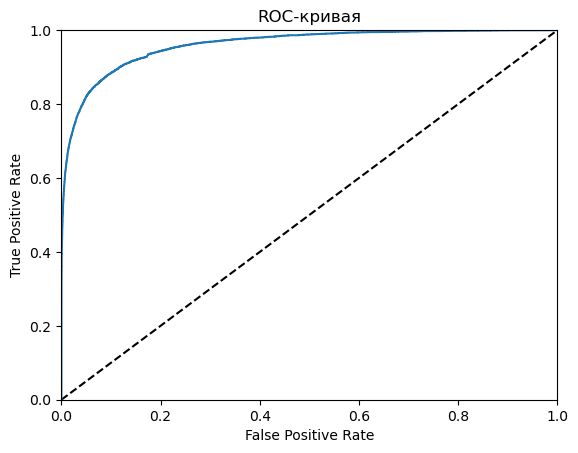

In [30]:
fpr, tpr, thresholds = roc_curve(target_test, model_log_res.predict_proba(all_test)[:, 1])
auc = roc_auc_score(target_test, probs_log_res_test)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Вместе с подобранным порогом результат тестовой выборки тоже удовлетворяет требованиям.

## Выводы

В ходе данной работы мы собирались составить модель машинного обучения, которая будет классифицировать комментарии правок на токсичные и нет. Для этого мы загрузили размеченные данные и лемматизировали тексты. После чего преобразовали слова в вектора при помощи TfidfVectorizer с удалением стоп-слов. 

В кандидаты моделей мы определили: логичестическую регрессию, классификацию с градиентным стохастическим спуском, случайный лес для классификации и градиентный бустинг CatBoost для классификации. Лучше всего себя показали логистическая регрессия и градиентный бустинг. Для первой пришлось подобрать порог для улучшения F1-меры. В качестве финалиста была выбрана лог. регрессия по метрике и скорости обучения, на которой проверили тестовую выборку. Результат оказался не сильно хуже. Итоговые значения:
- F1 на тренировочной выборке: 0.7592052243990552
- F1 на тестовой выборке: 0.7555555555555555

Рекомендую для анализа токсичности комментариев и правок использовать эту предложенную модель логистической регрессии, но нужно учитывать, что обучалась она только на английском языке. Для других языков потребуется новая модель.